In [1]:
# Imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
import os
from src.utils.preprocess_utils import midi_to_multiclass_vectors
from src.utils.ml_utils import create_dataloaders, train_model, test_model, plot_metrics

In [2]:
# Define dataset
class MidiDataset(Dataset):
    def __init__(self, data_dir, sequence_length=50, tick_resolution=50):
        self.data_dir = data_dir
        self.sequence_length = sequence_length
        self.tick_resolution = tick_resolution
        self.file_names = [f for f in os.listdir(data_dir) if f.endswith('.mid') or f.endswith('.midi')]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = os.path.join(self.data_dir, file_name)
        
        try:
            data = midi_to_multiclass_vectors(file_path, tick_resolution=self.tick_resolution)
            
            if len(data) < self.sequence_length:
                raise ValueError(f"File {file_name} is too short for sequence length {self.sequence_length}")
            
            # Pick a random starting index and crop the data to sequence_length
            start_idx = np.random.randint(0, len(data) - self.sequence_length + 1)
            cropped_data = data[start_idx:start_idx + self.sequence_length]

            x = np.array(cropped_data[:-1]) # Input
            y = np.array(cropped_data[1:]) # "Label"

            return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
        except Exception as e:
            print(f"Error processing {file_name}: {e}")
            # If the file is invalid or too short, retry with another random file
            new_idx = np.random.randint(0, len(self.file_names))
            return self.__getitem__(new_idx)

dataset_sequence_length = 50
tick_resolution = 400
dataset = MidiDataset(data_dir='data/midis', sequence_length=dataset_sequence_length, tick_resolution=tick_resolution)

In [3]:
# Get dataloaders with specified params from ml_utils
dataloader_train, dataloader_val, dataloader_test = create_dataloaders(dataset=dataset, batch_size=32, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, shuffle=True)

In [4]:
# Define model architecture
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, num_heads, hidden_size, num_layers, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.linear_in = nn.Linear(vocab_size, embedding_size)

        self.transformer = nn.Transformer(
            d_model=embedding_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_size,
            dropout=dropout,
            batch_first=True
        )

        self.linear_out = nn.Linear(embedding_size, vocab_size)
        
    def forward(self, src, tgt):
        # src: [batch_size, sequence_length-1, vocab_size]
        # tgt: [batch_size, sequence_length-1, vocab_size]

        src_embedded = self.linear_in(src)  # [batch_size, seq_len, d_model]
        tgt_embedded = self.linear_in(tgt)  # [batch_size, seq_len, d_model]

        transformer_output = self.transformer(src_embedded, tgt_embedded)  # [batch_size, sequence_length-1, vocab_size]

        output = self.linear_out(transformer_output) # [batch_size, seq_len, vocab_size]

        return output

vocab_size = 85  # Number of possible notes
embedding_size = 64
num_heads = 4  # Number of attention heads
hidden_size = 128  # Size of feedforward layers in transformer
num_layers = 3  # Number of transformer encoder layers
dropout = 0.2  # Dropout rate

model = TransformerModel(vocab_size, embedding_size, num_heads, hidden_size, num_layers, dropout)

Error processing Mozart, Wolfgang Amadeus, Piano Sonata in F major, K.Anh.29_590a, bUh99lCe1tU.mid: File Mozart, Wolfgang Amadeus, Piano Sonata in F major, K.Anh.29_590a, bUh99lCe1tU.mid is too short for sequence length 50
Error processing Horn, C. von, Die Nacht vergeht, jHScOCCVtdk.mid: File Horn, C. von, Die Nacht vergeht, jHScOCCVtdk.mid is too short for sequence length 50
Error processing Satie, Erik, Allegro, 3yGYXvq-scc.mid: File Satie, Erik, Allegro, 3yGYXvq-scc.mid is too short for sequence length 50
Error processing Berens, Hermann, 50 Piano Pieces for First Beginners, Op.70, 8I3SZtZHn2s.mid: File Berens, Hermann, 50 Piano Pieces for First Beginners, Op.70, 8I3SZtZHn2s.mid is too short for sequence length 50
Error processing Gumpelzhaimer, Adam, Was mein Gott will, das g'scheh allzeit, BTQegBbW13A.mid: max() arg is an empty sequence
Error processing Breslaur, Emil, Die leichtesten Klavierstücke, Op.46, fgIRzt9vfHI.mid: File Breslaur, Emil, Die leichtesten Klavierstücke, Op.46

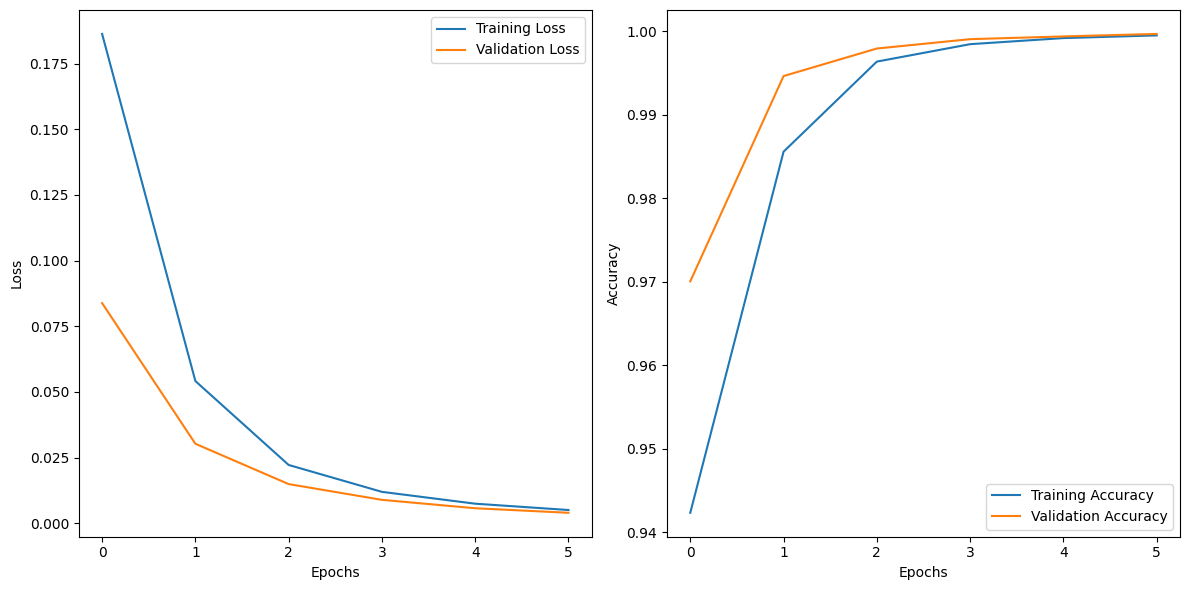

In [5]:
# Train model from ml_utils
best_model, history = train_model(
    model=model,
    dataloaders={"train": dataloader_train, "val": dataloader_val},
    task_type="multi-label",
    n_epochs=6,
    learning_rate=0.001,
    device="cuda"
)
(train_losses, val_losses, train_accuracy, val_accuracy) = history
plot_metrics(train_losses, val_losses, train_accuracy, val_accuracy)

In [6]:
# Test model from ml_utils
test_model(best_model, dataloader_test, nn.BCEWithLogitsLoss(), task_type="multi-label", device="cuda")

Error processing Bach, Carl Philipp Emanuel, Fantasia in D minor, H.224, U7Qg11-Rlug.mid: File Bach, Carl Philipp Emanuel, Fantasia in D minor, H.224, U7Qg11-Rlug.mid is too short for sequence length 50
Error processing Schubert, Franz, Ecossaise in D major, D.782, SIlfmpW_N80.mid: File Schubert, Franz, Ecossaise in D major, D.782, SIlfmpW_N80.mid is too short for sequence length 50
Error processing Spindler, Fritz, Hexenfahrt, Op.11, Gi_Zoy36LzQ.mid: File Spindler, Fritz, Hexenfahrt, Op.11, Gi_Zoy36LzQ.mid is too short for sequence length 50
Error processing Spindler, Fritz, Wellenspiel, Op.6, krXtgqRCAvU.mid: File Spindler, Fritz, Wellenspiel, Op.6, krXtgqRCAvU.mid is too short for sequence length 50
Error processing Schubert, Franz, Ecossaise, D.158, b34nNxbBBBY.mid: File Schubert, Franz, Ecossaise, D.158, b34nNxbBBBY.mid is too short for sequence length 50
Error processing Spindler, Fritz, Reiterlied, Op.38, 4IOer3zl6sM.mid: File Spindler, Fritz, Reiterlied, Op.38, 4IOer3zl6sM.mid 

(np.float64(0.0036631305428112253), np.float64(0.9997190914902032))

In [8]:
# Save model
from datetime import datetime

timestamp = datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
filename = f'weights/model_5/{timestamp}_e{embedding_size}_nh{num_heads}_h{hidden_size}_l{num_layers}_sl{dataset_sequence_length}_tr{tick_resolution}'

torch.save(best_model, filename)